![](../figs/se_03.png)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLDiego/uom_fse_dl_workshop/blob/main/solutions/SE03_SL_Training_neural_networks.ipynb)

## Workshop Overview
***
In this workshop, we explore autoencoders for unsupervised anomaly detection using real-world medical data. You'll learn how to build neural networks that learn to compress and reconstruct data, then use reconstruction error to identify abnormal patterns in heart sounds.

**Prerequisites**: Neural network basics (SE02), PyTorch fundamentals (SE01)

**Learning Objectives**:
- Understand the PyTorch training workflow from data to deployment
- Build and train autoencoders for dimensionality reduction
- Apply autoencoders for anomaly detection in medical audio
- Learn data preprocessing techniques for audio signals
- Implement proper train/validation/test splits
- Monitor and prevent overfitting using validation curves

**Clinical Context**: Early detection of cardiovascular and pulmonary diseases through heart and lung sound analysis can significantly improve patient outcomes. This workshop demonstrates how deep learning can assist in identifying abnormal patterns that may indicate underlying health conditions.

In [2]:
from pathlib import Path
import sys

# Setup paths for helper utilities
helper_utils = Path(Path.cwd().parent)
if str(helper_utils) not in sys.path:
    sys.path.append(str(helper_utils))

# Core libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Audio processing
import librosa
import librosa.display

# Utilities
import utils

# Initialize exercise checker and quiz manager
checker = utils.core.ExerciseChecker("SE03")
quizzer = utils.core.QuizManager("SE03")

print("✅ Libraries loaded successfully!")

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 1.0.1+30d0bf9
✅ Libraries loaded successfully!


# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="30"/> 1. The PyTorch Workflow
***

Most deep learning projects follow a systematic workflow. Whether you're building image classifiers, time series predictors, or anomaly detectors, the fundamental steps remain consistent. Understanding this workflow helps you structure your projects effectively.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="../figs/pytorch_workflow.png" alt="PyTorch WorkFlow" align="center" style="width: 80%; height: auto; margin: 0 auto;">
</figure>

## The Complete Workflow

| Step | Description | Key Considerations |
|------|------------|-------------------|
| 📊 **Obtain Data** | Collect and explore your dataset | Data quality, source reliability, licensing |
| 🔧 **Prepare Data** | Convert to PyTorch-compatible format | Tensors, data types, shapes |
| 🧹 **Preprocess Data** | Clean, normalize, and split data | Train/val/test splits, normalization strategy |
| ⚡ **Activation Function** | Choose non-linearity for neurons | ReLU for hidden layers, task-specific for output |
| 🏗️ **Model Architecture** | Define network structure | Layer types, sizes, depth |
| 🎯 **Choose Optimizer** | Select parameter update algorithm | Adam, SGD, learning rate |
| 📉 **Choose Loss Function** | Define what to minimize | MSE for regression, CE for classification |
| 🔄 **Create Training Loop** | Implement forward/backward passes | Gradient computation, parameter updates |
| 🏋️ **Fit Model** | Train on data | Epochs, batch size, early stopping |
| 📈 **Evaluate Model** | Test performance | Validation metrics, generalization |
| ⚙️ **Improve Model** | Fine-tune and optimize | Hyperparameter tuning, regularization |
| 💾 **Save/Deploy Model** | Productionize your solution | Model serialization, deployment strategy |

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Remember**: This workflow is iterative. You'll often cycle back to earlier steps as you refine your model.

## Step 1: Obtain Data
***

### The Heart and Lung Sounds Dataset (HLS-CMDS)

In this workshop, we'll use the [Heart and Lung Sounds - Clinical Manikin Digital Stethoscope (HLS-CMDS) dataset](https://github.com/Torabiy/HLS-CMDS). This dataset contains 535 recordings of heart and lung sounds captured using a digital stethoscope from a clinical manikin, simulating real physiological conditions.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Dataset Overview**:
> - **Total Recordings**: 535 audio files (.wav format)
> - **Recording Types**: 50 heart sounds, 50 lung sounds, 145 mixed sounds (+ 145 source heart + 145 source lung)
> - **Auscultation Locations**: 12 chest landmarks
> - **Sample Rate**: Varies by recording
> - **Duration**: Typically 5-10 seconds per recording

### Sound Categories

The dataset includes both **normal** and **abnormal** cardiopulmonary sounds:

| Category | Sound Types | Clinical Significance |
|----------|-------------|----------------------|
| **Normal Heart** | Regular cardiac rhythm | Healthy baseline |
| **Heart Abnormalities** | Murmurs (early/mid/late systolic, diastolic), Third/Fourth heart sounds, Atrial fibrillation, Tachycardia, AV block | Potential valve disease, arrhythmias, heart failure |
| **Normal Lung** | Clear breath sounds | Healthy baseline |
| **Lung Abnormalities** | Wheezing, Crackles (fine/coarse), Rhonchi, Pleural rub | Asthma, pneumonia, bronchitis, pleural inflammation |

### Why Autoencoders for Anomaly Detection?

Traditional supervised learning requires labeled examples of every abnormality type. However:

1. **Normal data is abundant** - healthy recordings are easy to collect
2. **Abnormalities are rare** - pathological sounds are less common
3. **Unknown patterns exist** - new or rare conditions may not be in training data

**Autoencoders solve this** by learning to reconstruct *normal* sounds. When presented with abnormal sounds, they produce higher reconstruction errors, flagging them as anomalies.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Key Insight**: We'll train our autoencoder primarily on normal heart sounds, then use reconstruction error as an anomaly score.

### Dataset Citation

If you use this dataset in research, please cite:
- Y. Torabi, S. Shirani and J. P. Reilly, "Descriptor: Heart and Lung Sounds Dataset Recorded from a Clinical Manikin using Digital Stethoscope (HLS-CMDS)," IEEE Data Descriptions, doi: 10.1109/IEEEDATA.2025.3566012

In [3]:
# Download and setup the HLS-CMDS dataset
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('HLS-CMDS',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=True)

print(f"✅ Dataset downloaded to: {dataset_path}")

Downloading:
Heart and Lung Sounds Dataset: 535 audio recordings of normal and abnormal cardiopulmonary sounds from clinical manikin for AI-based disease detection
> Authors: Yasaman Torabi, Shahram Shirani, James P. Reilly
> Year: 2025
> Website: https://archive.ics.uci.edu/dataset/1202/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope



Extracting hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope.zip: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope.zip
Found nested archive: HLS-CMDS.zip


Extracting HLS-CMDS.zip: 100%|██████████| 9/9 [00:00<00:00, 68.71it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/HLS-CMDS.zip
Found nested archive: HS.zip


Extracting HS.zip: 100%|██████████| 106/106 [00:00<00:00, 2689.62it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/HS.zip
Found nested archive: LS.zip


Extracting LS.zip: 100%|██████████| 106/106 [00:00<00:00, 2417.06it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/LS.zip
Found nested archive: Mix.zip


Extracting Mix.zip: 100%|██████████| 873/873 [00:00<00:00, 2683.98it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/Mix.zip
✅ Dataset downloaded to: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope


In [4]:
# Explore the dataset structure
import os

# List the contents of the dataset
print("📂 Dataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(str(dataset_path), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    
    # Show CSV files and a few WAV files
    csv_files = [f for f in files if f.endswith('.csv')]
    wav_files = [f for f in files if f.endswith('.wav') or f.endswith('.WAV')]
    
    for file in csv_files:
        print(f'{subindent}{file}')
    
    if wav_files:
        for file in wav_files[:3]:
            print(f'{subindent}{file}')
        if len(wav_files) > 3:
            print(f'{subindent}... and {len(wav_files) - 3} more WAV files')
    
    if level > 1:  # Limit depth
        break

# Load metadata CSV files
heart_metadata_path = dataset_path / 'HS.csv'
lung_metadata_path = dataset_path / 'LS.csv'
mix_metadata_path = dataset_path / 'Mix.csv'

# Get paths to audio folders
heart_sounds_folder = dataset_path / 'HS'
lung_sounds_folder = dataset_path / 'LS'
mix_sounds_folder = dataset_path / 'Mix'

print(f"\n✅ Located dataset components:")
print(f"   Heart sounds metadata (HS.csv): {heart_metadata_path.exists()}")
print(f"   Mix sounds metadata (Mix.csv): {mix_metadata_path.exists()}")

# Load Mix metadata (contains 145 heart, 145 lung, 145 mixed sounds)
if mix_metadata_path.exists():
    mix_metadata = pd.read_csv(mix_metadata_path)
    print(f"\n📊 Mix dataset loaded:")
    print(f"   Total recordings: {len(mix_metadata)}")
    print(f"   Columns: {list(mix_metadata.columns)}")
    print(f"\n   Sample of Mix metadata:")
    print(mix_metadata.head(10))
else:
    print("\n⚠️ Warning: Mix.csv not found!")

# Load HS metadata for testing
if heart_metadata_path.exists():
    heart_metadata = pd.read_csv(heart_metadata_path)
    print(f"\n📊 Heart sounds (HS) dataset loaded:")
    print(f"   Total recordings: {len(heart_metadata)}")
    print(f"   Sample:")
    print(heart_metadata.head())
else:
    print("\n⚠️ Warning: HS.csv not found!")

📂 Dataset structure:
hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/
  HS.csv
  Mix.csv
  LS.csv
  Mix/
    L0014.wav
    L0028.wav
    M0005.wav
    ... and 432 more WAV files
  __MACOSX/
    ._LS.csv
    ._HS.csv
    ._Mix.csv
  HS/
    M_ESM_RUSB.wav
    F_LDM_LUSB.wav
    F_ESM_LUSB.wav
    ... and 47 more WAV files
  LS/
    F_W_RUA.wav
    F_CC_LUA.wav
    M_PR_RMA.wav
    ... and 47 more WAV files

✅ Located dataset components:
   Heart sounds metadata (HS.csv): True
   Mix sounds metadata (Mix.csv): True

📊 Mix dataset loaded:
   Total recordings: 145
   Columns: ['Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location', 'Heart Sound ID', 'Lung Sound ID', 'Mixed Sound ID']

   Sample of Mix metadata:
  Gender       Heart Sound Type  Lung Sound Type Location Heart Sound ID  \
0      F   Late Systolic Murmur          Rhonchi     LUSB          H0001   
1      F                     S3           Normal      RLA          H0002   

In [5]:
heart_metadata.head()

,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Normal,RC,F_N_RC
1,F,Normal,LC,F_N_LC
2,M,Normal,RUSB,M_N_RUSB
3,F,Normal,LUSB,F_N_LUSB
4,F,Normal,LLSB,F_N_LLSB


## Step 2 and 3: Prepare and Preprocess Data
***

### Working with Audio Data

Audio signals are continuous waveforms that need to be converted into numerical representations for machine learning. We'll use **Mel Frequency Cepstral Coefficients (MFCCs)** - a compact representation of audio that captures the most important frequency characteristics.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **What are MFCCs?**: MFCCs are coefficients that represent the short-term power spectrum of a sound. They're widely used in speech and audio processing because they approximate how humans perceive sound.

### Audio to Features Pipeline

```
Raw Audio (.wav) → Short-Time Fourier Transform (STFT) → Mel Filterbank → MFCCs → Feature Vector
```

### Training, Validation, and Test Sets
***

Just as in supervised learning, we need to split our data into separate sets. For autoencoders:

| Dataset | Purpose | Typical Split | Usage | Content for Our Task |
|---------|---------|---------------|--------|----------------------|
| **Training Set** | Learn to reconstruct normal patterns | 60-70% | Every training iteration | Primarily normal heart sounds |
| **Validation Set** | Monitor reconstruction quality during training | 15-20% | During model development | Mix of normal and some abnormal sounds |
| **Test Set** | Final evaluation of anomaly detection | 15-20% | Once, after training | Balanced mix of normal and abnormal sounds |

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Key Difference**: Unlike supervised learning, our training set contains mostly normal examples. The model learns what "normal" looks like, and anomalies naturally produce higher reconstruction errors.

### Normalization

Normalization is crucial for neural network training. For audio features, we'll use **Standard Scaling** (Z-score normalization):

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ is the normalized value
- $x$ is the original value
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation

| Benefit | Description | Impact on Training |
|---------|-------------|--------------------|
| **Faster Convergence** | Normalized inputs lead to better-conditioned optimization | Reduces training time |
| **Numerical Stability** | Prevents extremely large or small values | Reduces gradient issues |
| **Feature Scaling** | All features contribute equally | Balanced learning |
| **Better Generalization** | Helps transfer across different recordings | Improved performance on unseen data |

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Important**: Fit the scaler only on training data, then transform all datasets to prevent information leakage.

In [6]:
# Helper function to load and extract features from audio files
def extract_mfcc_features(file_path, n_mfcc=13, max_len=130):
    """
    Extract MFCC features from an audio file
    
    Args:
        file_path: Path to the audio file
        n_mfcc: Number of MFCC coefficients to extract
        max_len: Maximum length to pad/truncate the features
    
    Returns:
        Flattened MFCC feature vector
    """
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Pad or truncate to fixed length
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]
    
    # Flatten to 1D vector
    return mfccs.flatten()

# Strategy: Use Mix dataset (145 heart sounds) for TRAINING
#           Use HS dataset for TESTING
# This gives us more training data and keeps test set independent

print("=" * 70)
print("TRAINING SET: Loading from Mix dataset (Source Heart Sounds)")
print("=" * 70)

# The Mix.csv contains references to source heart sounds
# We need to identify which files are the 145 source heart sounds
print(f"\n📊 Analyzing Mix metadata structure:")
print(f"Columns: {list(mix_metadata.columns)}")

# Look for heart sound column
heart_sound_columns = [col for col in mix_metadata.columns if 'heart' in col.lower() or 'H ' in col or col.startswith('H')]
if heart_sound_columns:
    print(f"Found heart sound columns: {heart_sound_columns}")
    heart_sound_col = heart_sound_columns[0]
else:
    # Try common alternatives
    possible_cols = ['H Sound ID', 'Heart Sound', 'HS ID']
    heart_sound_col = None
    for col in possible_cols:
        if col in mix_metadata.columns:
            heart_sound_col = col
            break
    if not heart_sound_col:
        heart_sound_col = mix_metadata.columns[1] if len(mix_metadata.columns) > 1 else mix_metadata.columns[0]

print(f"Using column: '{heart_sound_col}'")

# Extract unique heart sound files from Mix dataset
mix_heart_files = mix_metadata[heart_sound_col].unique()
print(f"\n✅ Found {len(mix_heart_files)} unique heart sounds in Mix dataset")

TRAINING SET: Loading from Mix dataset (Source Heart Sounds)

📊 Analyzing Mix metadata structure:
Columns: ['Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location', 'Heart Sound ID', 'Lung Sound ID', 'Mixed Sound ID']
Found heart sound columns: ['Heart Sound Type', 'Heart Sound ID']
Using column: 'Heart Sound Type'

✅ Found 10 unique heart sounds in Mix dataset


In [7]:
# Load features from Mix heart sounds (for training)
print("\n🎵 Loading heart sounds from Mix folder (for training)...")
train_features = []
train_sound_ids = []

for sound_id in tqdm(mix_heart_files, desc="Processing Mix heart sounds"):
    # Ensure sound_id is a string and clean it
    sound_id = str(sound_id).strip()
    if sound_id == 'nan' or pd.isna(sound_id):
        continue
        
    file_path = mix_sounds_folder / sound_id
    
    # Try both .wav and .WAV extensions
    if not file_path.exists():
        file_path = mix_sounds_folder / sound_id.replace('.wav', '.WAV')
    if not file_path.exists() and not sound_id.endswith(('.wav', '.WAV')):
        file_path = mix_sounds_folder / f"{sound_id}.WAV"
    
    if file_path.exists():
        try:
            features = extract_mfcc_features(file_path)
            train_features.append(features)
            train_sound_ids.append(sound_id)
        except Exception as e:
            print(f"Error processing {sound_id}: {e}")

train_features = np.array(train_features)
print(f"✅ Loaded {len(train_features)} heart sounds from Mix dataset for TRAINING")
print(f"   Feature shape per recording: {train_features.shape}")

print("\n" + "=" * 70)
print("TEST SET: Loading from HS dataset (Independent Test Set)")
print("=" * 70)

# Load HS dataset for testing - separate normal and abnormal
normal_mask = heart_metadata['Sound'] == 'NH'
abnormal_mask = ~normal_mask

normal_test_files = heart_metadata[normal_mask]['Sound ID'].tolist()
abnormal_test_files = heart_metadata[abnormal_mask]['Sound ID'].tolist()

print(f"\n📊 HS dataset composition:")
print(f"   Normal (NH): {len(normal_test_files)}")
print(f"   Abnormal: {len(abnormal_test_files)}")
print(f"   Abnormal types: {heart_metadata[abnormal_mask]['Sound'].unique()}")

# Load normal test sounds
print("\n🎵 Loading normal heart sounds from HS (for testing)...")
normal_test_features = []

for sound_id in tqdm(normal_test_files, desc="Processing normal HS sounds"):
    file_path = heart_sounds_folder / sound_id
    
    if not file_path.exists():
        file_path = heart_sounds_folder / sound_id.replace('.wav', '.WAV')
    
    if file_path.exists():
        try:
            features = extract_mfcc_features(file_path)
            normal_test_features.append(features)
        except Exception as e:
            print(f"Error processing {sound_id}: {e}")

normal_test_features = np.array(normal_test_features)
print(f"✅ Loaded {len(normal_test_features)} normal sounds from HS")

# Load abnormal test sounds
print("\n🚨 Loading abnormal heart sounds from HS (for testing)...")
abnormal_test_features = []
abnormal_test_labels = []

for sound_id in tqdm(abnormal_test_files, desc="Processing abnormal HS sounds"):
    file_path = heart_sounds_folder / sound_id
    
    if not file_path.exists():
        file_path = heart_sounds_folder / sound_id.replace('.wav', '.WAV')
    
    if file_path.exists():
        try:
            features = extract_mfcc_features(file_path)
            abnormal_test_features.append(features)
            # Get sound type from metadata
            sound_type = heart_metadata[heart_metadata['Sound ID'] == sound_id]['Sound'].values[0]
            abnormal_test_labels.append(sound_type)
        except Exception as e:
            print(f"Error processing {sound_id}: {e}")

abnormal_test_features = np.array(abnormal_test_features)
print(f"✅ Loaded {len(abnormal_test_features)} abnormal sounds from HS")

print("\n" + "=" * 70)
print("DATASET SUMMARY")
print("=" * 70)
print(f"Training set (Mix heart sounds): {len(train_features)} samples")
print(f"Test set (HS):")
print(f"  - Normal: {len(normal_test_features)} samples")
print(f"  - Abnormal: {len(abnormal_test_features)} samples")
print(f"  - Total test: {len(normal_test_features) + len(abnormal_test_features)} samples")
print(f"\nFeature dimensions: {train_features.shape[1]}")


🎵 Loading heart sounds from Mix folder (for training)...


Processing Mix heart sounds: 100%|██████████| 10/10 [00:00<00:00, 3874.29it/s]

✅ Loaded 0 heart sounds from Mix dataset for TRAINING
   Feature shape per recording: (0,)

TEST SET: Loading from HS dataset (Independent Test Set)


KeyError: 'Sound'

In [ ]:
# Understand the data distribution
print("📊 Training Data Analysis (Mix dataset):")
print(f"   Total training samples: {len(train_features)}")
print(f"   All samples will be used for training the autoencoder")
print(f"   (Training on Mix heart sounds assumed to be normal patterns)")

print("\n📊 Test Data Analysis (HS dataset):")
print(f"   Normal samples: {len(normal_test_features)}")
print(f"   Abnormal samples: {len(abnormal_test_features)}")
if abnormal_test_labels:
    print(f"   Abnormal types: {set(abnormal_test_labels)}")

# Sound type descriptions
sound_type_map = {
    'NH': 'Normal Heart',
    'LDM': 'Late Diastolic Murmur',
    'MSM': 'Mid Systolic Murmur',
    'LSM': 'Late Systolic Murmur',
    'AF': 'Atrial Fibrillation',
    'S4': 'Fourth Heart Sound',
    'ESM': 'Early Systolic Murmur',
    'S3': 'Third Heart Sound',
    'T': 'Tachycardia',
    'AVB': 'Atrioventricular Block'
}

if abnormal_test_labels:
    print("\n🎵 Abnormal sound types in test set:")
    for sound_type in set(abnormal_test_labels):
        count = abnormal_test_labels.count(sound_type)
        description = sound_type_map.get(sound_type, 'Unknown')
        print(f"   {sound_type}: {description} ({count} samples)")


📊 Total dataset:
   Normal samples: 9
   Abnormal samples: 12
   Feature dimensions: 1690


In [ ]:
# Split data into train/validation/test sets
# Strategy: 
#   - Training: Use Mix dataset (145 heart sounds) - split into train/val
#   - Testing: Use HS dataset (normal + abnormal) - completely independent

# Split Mix heart sounds into training and validation (80/20)
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(
    train_features, test_size=0.2, random_state=42
)

# Create labels for training/validation (all normal from Mix)
y_train = np.zeros(len(X_train))
y_val = np.zeros(len(X_val))

# Test set from HS dataset (normal + abnormal)
X_test = np.vstack([normal_test_features, abnormal_test_features])
y_test = np.concatenate([
    np.zeros(len(normal_test_features)),
    np.ones(len(abnormal_test_features))
])

print("📊 Final Dataset Splits:")
print("=" * 70)
print(f"TRAINING SET (from Mix):")
print(f"   Samples: {X_train.shape[0]}")
print(f"   Normal: {X_train.shape[0]} (100%)")
print(f"   Source: Mix folder")

print(f"\nVALIDATION SET (from Mix):")
print(f"   Samples: {X_val.shape[0]}")
print(f"   Normal: {X_val.shape[0]} (100%)")
print(f"   Source: Mix folder")

print(f"\nTEST SET (from HS - Independent):")
print(f"   Samples: {X_test.shape[0]}")
print(f"   Normal: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"   Abnormal: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
print(f"   Source: HS folder")

print("\n✅ Dataset ready for autoencoder training!")

📊 Dataset splits:
   Training:   6 samples (100% normal)
   Validation: 7 samples (1 normal, 6 abnormal)
   Test:       8 samples (2 normal, 6 abnormal)


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Select sample files for visualization
# Use a training sample (from Mix) and an abnormal test sample (from HS)
train_sample_idx = 0
normal_test_sample_id = normal_test_files[0]
abnormal_test_sample_id = abnormal_test_files[0]

# Helper to find file path supporting different extensions
def get_audio_path(sound_folder, sound_id):
    path = sound_folder / sound_id
    if not path.exists():
        path = sound_folder / sound_id.replace('.wav', '.WAV')
    return path

# Load audio data from Mix (training)
train_sample_id = str(mix_heart_files[train_sample_idx])
y_train, sr_train = librosa.load(get_audio_path(mix_sounds_folder, train_sample_id), sr=None)

# Load audio data from HS (test)
y_abnormal, sr_abnormal = librosa.load(get_audio_path(heart_sounds_folder, abnormal_test_sample_id), sr=None)

# Compute Mel Spectrograms
S_dB_train = librosa.power_to_db(librosa.feature.melspectrogram(y=y_train, sr=sr_train), ref=np.max)
S_dB_abnormal = librosa.power_to_db(librosa.feature.melspectrogram(y=y_abnormal, sr=sr_abnormal), ref=np.max)

# Create interactive subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        f"Training (Mix) - Waveform", "Training (Mix) - Mel Spectrogram",
        f"Abnormal Test (HS) - Waveform", "Abnormal Test (HS) - Mel Spectrogram"
    ),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Time axes for waveforms
t_train = np.linspace(0, len(y_train)/sr_train, len(y_train))
t_abnormal = np.linspace(0, len(y_abnormal)/sr_abnormal, len(y_abnormal))

# Add Waveforms
fig.add_trace(go.Scatter(x=t_train, y=y_train, name="Training", line=dict(color='#1f77b4', width=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=t_abnormal, y=y_abnormal, name="Abnormal", line=dict(color='#d62728', width=1)), row=2, col=1)

# Add Spectrograms
fig.add_trace(go.Heatmap(z=S_dB_train, colorscale='Viridis', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=S_dB_abnormal, colorscale='Viridis', showscale=False), row=2, col=2)

# Update layout
fig.update_layout(
    height=800, 
    title_text="Heart Sound Comparison: Training (Mix) vs Abnormal Test (HS)",
    template="plotly_white",
    showlegend=False
)

# Label axes
fig.update_xaxes(title_text="Time (s)", row=1, col=1)
fig.update_xaxes(title_text="Time (s)", row=2, col=1)
fig.update_yaxes(title_text="Amplitude", row=1, col=1)
fig.update_yaxes(title_text="Mel Bin", row=1, col=2)

fig.show()

print("👀 Hover over the plots to explore the audio patterns interactively!")
print(f"   Top: Training sample from Mix dataset")
print(f"   Bottom: Abnormal test sample from HS dataset")

👀 Hover over the plots to explore the audio patterns interactively!


### Normalization
***

Normalization is crucial for neural network training. We'll use **Standard Scaling** (Z-score normalization) for our MFCC features:

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ is the normalized value  
- $x$ is the original value
- $\mu$ is the mean computed from training data
- $\sigma$ is the standard deviation computed from training data

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Critical**: Always fit the scaler on training data only, then apply to validation and test sets. This prevents data leakage!

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 1**: Standard Scaling with scikit-learn

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on training data only
scaler.fit(X_train)

# Transform all datasets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Inverse transform to get original values
X_train_original = scaler.inverse_transform(X_train_scaled)
```

In [22]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 1: Data Normalization and Tensor Conversion 🎯

# In this exercise, you will:
# 1. Normalize the audio features using StandardScaler
# 2. Convert numpy arrays to PyTorch tensors
# 3. Verify the normalization worked correctly

# Create a StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on training data
scaler.fit(X_train)

# Transform all datasets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Verify normalization
print("📊 Normalization check:")
print(f"   Training data - Mean: {X_train_tensor.mean().item():.6f}, Std: {X_train_tensor.std().item():.4f}")
print(f"   Validation data - Mean: {X_val_tensor.mean().item():.6f}, Std: {X_val_tensor.std().item():.4f}")
print(f"   Test data - Mean: {X_test_tensor.mean().item():.6f}, Std: {X_test_tensor.std().item():.4f}")

print(f"\n✅ Data shapes:")
print(f"   Train: {X_train_tensor.shape}")
print(f"   Validation: {X_val_tensor.shape}")
print(f"   Test: {X_test_tensor.shape}")


📊 Normalization check:
   Training data - Mean: 0.000000, Std: 0.9528
   Validation data - Mean: -0.224061, Std: 1.4194
   Test data - Mean: -0.387588, Std: 1.5657

✅ Data shapes:
   Train: torch.Size([6, 1690])
   Validation: torch.Size([7, 1690])
   Test: torch.Size([8, 1690])


## Step 4: Activation Function
***
The next step is to choose an activation function for the model. The activation function introduces non-linearity to the model, allowing it to learn complex relationships in the data. The following table lists some common activation functions used in neural networks, along with their characteristics and best use cases:

| Function | Formula | Range | PyTorch Implementation | Best Used For |
|----------|---------|-------|-------------------|---------------|
| ReLU | $f(x) = \max(0, x)$ | $[0, \infty)$ | `torch.nn.ReLU()` | Hidden layers in most networks |
| Sigmoid | $f(x) = \frac{1}{1+e^{-x}}$ | $(0, 1)$ | `torch.nn.Sigmoid()` | Binary classification, gates in LSTMs |
| Tanh | $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | $(-1, 1)$ | `torch.nn.Tanh()` | Hidden layers when output normalization is needed |
| Leaky ReLU | $f(x) = \max(\alpha x, x)$ | $(-\infty, \infty)$ | `torch.nn.LeakyReLU(negative_slope=0.01)` | Preventing "dead neurons" problem |
| Softmax | $f(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$ | $(0, 1)$ | `torch.nn.Softmax(dim=1)` | Multi-class classification output layer |

The choice of activation function depends on the specific problem and the architecture of the neural network. 

> <img src="../figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - ReLU is the most commonly used activation function in hidden layers of deep networks due to its simplicity and effectiveness.
> - The activation function for the output layer depends on the type of problem being solved (e.g., regression, binary classification, multi-class classification).
***
> <img src="../figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> **Common Mistakes to Avoid**: 
> - Mixing activation functions in the same layer (e.g., using ReLU and sigmoid together) can lead to unexpected behavior.
> - Using activation functions that saturate (like sigmoid) in hidden layers can lead to vanishing gradients, making training difficult.
> - Forgetting to apply the activation function to the output layer can lead to incorrect predictions (e.g., not using softmax for multi-class classification).
> - Not considering the range of the output when choosing the activation function (e.g., using sigmoid for regression tasks).


## Step 5: Model Architecture - Introducing Autoencoders
***

### What is an Autoencoder?

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: An **autoencoder** is a neural network trained to reconstruct its input. It learns to compress data into a lower-dimensional representation (encoding) and then reconstruct it back (decoding).

### Architecture Components

An autoencoder consists of two main parts:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="../figs/autoencoder.png" alt="Autoencoder Architecture" align="center" style="width: 60%; height: auto; margin: 0 auto;" onerror="this.style.display='none'">
</figure>

| Component | Description | Mathematical Representation |
|-----------|-------------|----------------------------|
| **Encoder** | Compresses input to lower dimensions | $\mathbf{z} = f_{enc}(\mathbf{x})$ |
| **Latent Space** | Compressed representation (bottleneck) | $\mathbf{z} \in \mathbb{R}^d$ where $d << n$ |
| **Decoder** | Reconstructs input from latent space | $\mathbf{\hat{x}} = f_{dec}(\mathbf{z})$ |

### Why Autoencoders for Anomaly Detection?

The key insight: **If trained only on normal data, the autoencoder learns to reconstruct normal patterns well but struggles with abnormal patterns.**

| Scenario | Reconstruction Error | Interpretation |
|----------|---------------------|----------------|
| Normal heart sound | Low (≈ 0) | Model has seen similar patterns |
| Abnormal heart sound | High (>> 0) | Model hasn't learned this pattern |

### Mathematical Formulation

For input $\mathbf{x} \in \mathbb{R}^n$:

**Encoding:**
$$\mathbf{z} = \sigma(\mathbf{W}_{enc}\mathbf{x} + \mathbf{b}_{enc})$$

**Decoding:**
$$\mathbf{\hat{x}} = \sigma(\mathbf{W}_{dec}\mathbf{z} + \mathbf{b}_{dec})$$

**Reconstruction Error:**
$$\mathcal{L} = ||\mathbf{x} - \mathbf{\hat{x}}||^2 = \sum_{i=1}^{n}(x_i - \hat{x}_i)^2$$

### Network Design Considerations

| Layer Type | Encoder | Decoder | Activation |
|------------|---------|---------|------------|
| **Input Layer** | Feature dimension (e.g., 1690) | Latent dimension (e.g., 32) | - |
| **Hidden Layer 1** | 512 neurons | 128 neurons | ReLU |
| **Hidden Layer 2** | 128 neurons | 512 neurons | ReLU |
| **Output Layer** | 32 neurons (latent) | Original dimension | Linear/Sigmoid |

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Symmetric Architecture**: Decoders typically mirror encoders. If encoder is [1690 → 512 → 128 → 32], decoder is [32 → 128 → 512 → 1690].

### Latent Space Dimensionality

The bottleneck dimension determines compression strength:

- **Too large** (e.g., 512): Model may memorize noise, poor anomaly detection
- **Too small** (e.g., 8): Loses important information, poor reconstruction  
- **Sweet spot** (e.g., 32-64): Captures essential patterns, discards noise


### Initialising Weights and Biases
***

In the previous session we looked at the concept of weights and biases. With our Perceptron we initialised the weights and biases to random values. In PyTorch, we can use different methods to initialise the weights and biases of a neural network.

The importance of initialising weights and biases lies in the fact that they can significantly affect the convergence speed and performance of the neural network. Proper initialisation can help prevent issues such as vanishing or exploding gradients, which can hinder the training process.

| Initialisation Method | Formula | PyTorch Code | Description |
|-----------------------|----------|--------------|-------------|
| Xavier/Glorot Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}})$ | `torch.nn.init.xavier_uniform_(tensor)` | Suitable for sigmoid and tanh activations. |
| He Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Kaiming Normal Initialisation | $W \sim \mathcal{N}(0, \sqrt{\frac{2}{n_{in}}})$ | `torch.nn.init.kaiming_normal_(tensor)` | Suitable for ReLU activations. |
| Kaiming Uniform Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Zero Initialisation | $W = 0$ | `torch.nn.init.zeros_(tensor)` | All weights are set to zero. Not recommended. |
| Random Initialisation | $W \sim \mathcal{U}(-1, 1)$ | `torch.nn.init.uniform_(tensor)` | Weights are randomly initialised between -1 and 1. |
***
> <img src="../figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - Use Xavier or He initialisation for most cases, as they are designed to maintain the variance of activations across layers.
> - Avoid zero initialisation, as it can lead to symmetry problems where all neurons learn the same features.
> - PyTorch uses Kaiming initialisation by default for `torch.nn.Linear` layers, which is suitable for ReLU activations.
> - Experiment with different initialisation methods to see their impact on training speed and model performance.


In [23]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 2: Build an Autoencoder 🎯

# In this exercise, you will:
# 1. Create an autoencoder architecture with encoder and decoder
# 2. Initialize weights properly
# 3. Implement the forward pass for reconstruction

class HeartSoundAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        """
        Autoencoder for heart sound anomaly detection
        
        Args:
            input_dim: Dimension of input features (MFCC flattened)
            latent_dim: Dimension of latent space (bottleneck)
        """
        super(HeartSoundAutoencoder, self).__init__()
        
        # Encoder: Compress input to latent representation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        
        # Decoder: Reconstruct input from latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
            # No activation on final layer - we want continuous output
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """Forward pass: encode then decode"""
        # Encode to latent space
        z = self.encoder(x)
        
        # Decode to reconstruct input
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed
    
    def encode(self, x):
        """Get latent representation only"""
        return self.encoder(x)

# Initialize the autoencoder
input_dim = X_train_tensor.shape[1]
latent_dim = 32

model = HeartSoundAutoencoder(input_dim=input_dim, latent_dim=latent_dim)

print("🏗️ Autoencoder Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Input dimension: {input_dim}")
print(f"   Latent dimension: {latent_dim}")
print(f"   Compression ratio: {input_dim/latent_dim:.1f}x")


🏗️ Autoencoder Architecture:
HeartSoundAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1690, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1690, bias=True)
  )
)

📊 Model Statistics:
   Total parameters: 1,872,826
   Trainable parameters: 1,872,826
   Input dimension: 1690
   Latent dimension: 32
   Compression ratio: 52.8x


## Step 6 and 7: Choose Optimizer and Loss Function  
***

### Optimizer Selection

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: Optimizers are algorithms that update model parameters to minimize the loss function using gradients computed via backpropagation.

| Optimizer | PyTorch Implementation | Best Used For | Learning Rate |
|-----------|----------------------|---------------|---------------|
| **Adam** | `torch.optim.Adam(params, lr=0.001)` | Most deep learning tasks | 1e-3 to 1e-4 |
| SGD | `torch.optim.SGD(params, lr=0.01, momentum=0.9)` | When you need momentum | 1e-2 to 1e-1 |
| RMSProp | `torch.optim.RMSprop(params, lr=0.001)` | RNNs and time series | 1e-3 to 1e-4 |
| AdamW | `torch.optim.AdamW(params, lr=0.001, weight_decay=0.01)` | When regularization matters | 1e-3 to 1e-4 |

**For autoencoders**, Adam is typically the best choice due to its adaptive learning rates and momentum.

### Loss Function for Autoencoders

Unlike classification (cross-entropy) or supervised regression (MSE on targets), autoencoders use **reconstruction loss** - they compare the input with the reconstructed output.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Key Insight**: Autoencoders don't need separate labels! The input $\mathbf{x}$ serves as both input and target.

**Training objective:** Minimize $\mathcal{L} = ||\mathbf{x} - \mathbf{\hat{x}}||^2$

| Loss Function | Formula | PyTorch Implementation | Use Case |
|---------------|---------|----------------------|----------|
| **MSE (L2 Loss)** | $\mathcal{L} = \frac{1}{n}\sum_{i=1}^{n}(x_i - \hat{x}_i)^2$ | `nn.MSELoss()` | General reconstruction |
| MAE (L1 Loss) | $\mathcal{L} = \frac{1}{n}\sum_{i=1}^{n}|x_i - \hat{x}_i|$ | `nn.L1Loss()` | Robust to outliers |
| Binary Cross-Entropy | $\mathcal{L} = -\sum_{i=1}^{n}[x_i\log(\hat{x}_i) + (1-x_i)\log(1-\hat{x}_i)]$ | `nn.BCELoss()` | Binary features [0,1] |

**For our MFCC features**, MSE Loss is appropriate since:
- Features are continuous (not binary)
- We want to penalize larger errors more heavily
- Standard practice for audio reconstruction

### Loss Function Behavior

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="../figs/losses.png" alt="Loss Functions" align="center" style="width: 30%; height: auto; margin: 0 auto;">
</figure>

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Remember**: The reconstruction loss measures how well the autoencoder has learned to represent normal patterns. Lower loss on training data = better compression. Higher loss on abnormal data = successful anomaly detection.

In [24]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 3: Optimizer and Loss Function Setup 🎯

# In this exercise, you will:
# 1. Select an appropriate optimizer for the autoencoder
# 2. Choose the right loss function for reconstruction
# 3. Set an appropriate learning rate

# Create an Adam optimizer for the autoencoder
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create MSE loss for reconstruction
loss_function = nn.MSELoss()

# Print configuration
print("⚙️ Training Configuration:")
print(f"   Optimizer: {type(optimizer).__name__}")
print(f"   Learning rate: {learning_rate}")
print(f"   Loss function: {type(loss_function).__name__}")
print(f"   Number of trainable parameters: {sum(p.numel() for p in model.parameters()):,}")


⚙️ Training Configuration:
   Optimizer: Adam
   Learning rate: 0.001
   Loss function: MSELoss
   Number of trainable parameters: 1,872,826


## Step 8 and 9: Create Training Loop and Fit Model
***

### The Autoencoder Training Loop

The training loop for autoencoders follows the standard PyTorch workflow, but with a key difference: **the input is also the target**. We're training the model to reconstruct its own input.

| Step | Description | Code Example | Purpose |
|------|-------------|--------------|---------|
| 1. **Forward Pass** | Pass input through encoder and decoder | `reconstructed = model(input)` | Get reconstruction |
| 2. **Loss Computation** | Compare input with reconstruction | `loss = criterion(reconstructed, input)` | Measure quality |
| 3. **Backward Pass** | Compute gradients | `loss.backward()` | Calculate updates |
| 4. **Parameter Updates** | Update weights | `optimizer.step()` | Improve model |
| 5. **Gradient Reset** | Zero gradients | `optimizer.zero_grad()` | Prepare for next batch |

### Monitoring Training

For autoencoders, we track:
- **Training loss**: Reconstruction error on normal training data (should decrease)
- **Validation loss**: Reconstruction error on validation set (should decrease but stay close to training)

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 2**: Autoencoder Training Loop Structure

```python
for epoch in range(num_epochs):
    # Training mode
    model.train()
    
    # 1. Forward Pass: Reconstruct input
    reconstructed = model(input_data)
    
    # 2. Loss Computation: Compare input with reconstruction
    loss = criterion(reconstructed, input_data)  # Note: target = input!
    
    # 3. Backward Pass
    loss.backward()
    
    # 4. Parameter Updates
    optimizer.step()
    
    # 5. Gradient Reset
    optimizer.zero_grad()
    
    # Validation (no gradients needed)
    model.eval()
    with torch.no_grad():
        val_reconstructed = model(val_data)
        val_loss = criterion(val_reconstructed, val_data)
```

### Epochs and Training Duration

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: An **epoch** is one complete pass through the entire training dataset.

| Epochs | Training Time | Risk | Recommendation |
|--------|---------------|------|----------------|
| Too few (< 50) | Fast | Underfitting - poor reconstruction | Start here, increase if needed |
| Optimal (100-300) | Moderate | Good balance | Monitor validation loss |
| Too many (> 500) | Slow | Overfitting - memorizes noise | Use early stopping |


🏋️ Training autoencoder on normal heart sounds...


Training Autoencoder: 100%|██████████| 200/200 [00:01<00:00, 166.48it/s]


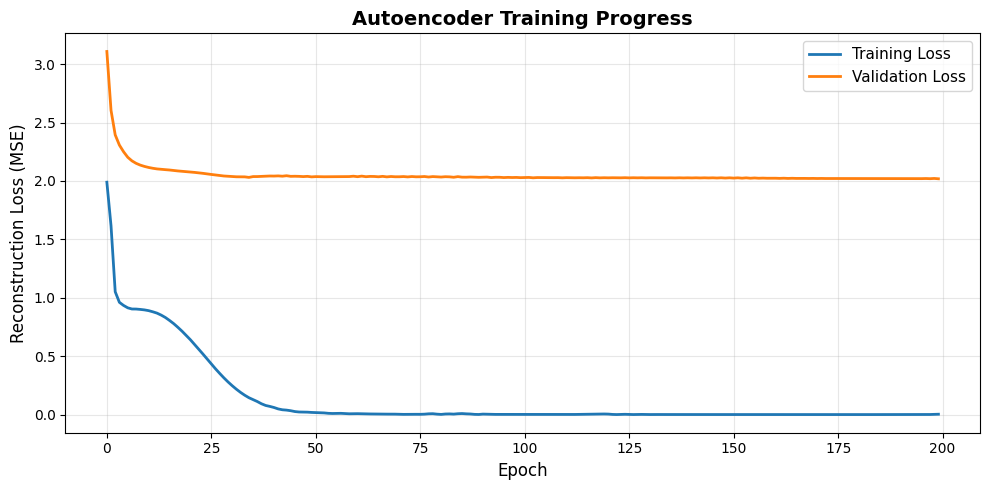


✅ Training complete!
   Final training loss: 0.002982
   Final validation loss: 2.018257


In [25]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 4: Training the Autoencoder 🎯

# In this exercise, you will:
# 1. Implement a complete training loop for the autoencoder
# 2. Monitor training and validation losses
# 3. Track reconstruction quality over epochs

def train_autoencoder(model, 
                     train_data, 
                     val_data, 
                     optimizer, 
                     criterion,
                     epochs=200):
    """
    Train an autoencoder model
    
    Args:
        model: PyTorch autoencoder model
        train_data: Training features (input = target for autoencoders!)
        val_data: Validation features
        optimizer: PyTorch optimizer
        criterion: Loss function
        epochs: Number of training epochs
        
    Returns:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
    """
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs), desc="Training Autoencoder"):
        # === TRAINING PHASE ===
        model.train()
        
         # 1. Zero gradients
        optimizer.zero_grad()
        
        # 2. Forward pass: Reconstruct the input
        reconstructed = model(train_data)
        
        # 3. Compute reconstruction loss (compare input with reconstruction)
        train_loss = criterion(reconstructed, train_data)  # Target = input!
        
        # 4. Backward pass
        train_loss.backward()
        
        # 5. Update weights
        optimizer.step()
        
        # Store training loss
        train_losses.append(train_loss.item())
        
        # === VALIDATION PHASE ===
        model.eval()
        with torch.no_grad():
            val_reconstructed = model(val_data)
            val_loss = criterion(val_reconstructed, val_data)
            val_losses.append(val_loss.item())
    
    return train_losses, val_losses

# Train the model
print("🏋️ Training autoencoder on normal heart sounds...")
train_losses, val_losses = train_autoencoder(
    model=model,
    train_data=X_train_tensor,
    val_data=X_val_tensor,
    optimizer=optimizer,
    criterion=loss_function,
    epochs=200
)

# Plot training progress
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Training Loss', linewidth=2)
ax.plot(val_losses, label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Reconstruction Loss (MSE)', fontsize=12)
ax.set_title('Autoencoder Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Training complete!")
print(f"   Final training loss: {train_losses[-1]:.6f}")
print(f"   Final validation loss: {val_losses[-1]:.6f}")



### Overfitting, Underfitting, and Early Stopping
***
> <img src="../figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Overfitting occurs when a model learns the training data too well, including noise and outliers, leading to poor generalisation on unseen data. Underfitting occurs when a model is too simple to capture the underlying patterns in the data.

As we can see in the following figure, the training loss decreases over time, while the validation loss follows a similar trend. However, the validation loss starts to slowly deviate from the training loss after a certain number of epochs. This indicates that the model is starting to overfit the training data. The point at which the validation loss starts to increase is known as the "early stopping" point. This is the point at which we should stop training the model to prevent overfitting.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="../figs\over_under_fit.png" alt="Overfitting" align="center" style="width: 60%; height: auto; margin: 0 auto;">

## Step 10: Evaluate Model - Anomaly Detection
***

### Using Reconstruction Error for Anomaly Detection

The core principle: **Models trained on normal data struggle to reconstruct abnormal patterns.**

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Anomaly Score**: The reconstruction error serves as an anomaly score. Higher error = more abnormal.

$$\text{Anomaly Score} = ||\mathbf{x} - \mathbf{\hat{x}}||^2 = \sum_{i=1}^{n}(x_i - \hat{x}_i)^2$$

### Evaluation Strategy

1. **Compute reconstruction errors** for all test samples
2. **Set a threshold** to distinguish normal from abnormal
3. **Calculate metrics**: Accuracy, precision, recall, F1-score
4. **Visualize** the distribution of errors for normal vs. abnormal sounds

### Choosing the Threshold

| Method | Description | When to Use |
|--------|-------------|-------------|
| **Statistical** | Mean + k×std of normal training errors | When normal data is clean |
| **Percentile** | 95th or 99th percentile of training errors | Robust to outliers |
| **ROC-based** | Threshold that maximizes TPR - FPR | When you have validation labels |
| **Domain-specific** | Clinical guidelines | When expert knowledge exists |

### Performance Metrics

For anomaly detection:

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **True Positive Rate (Recall)** | $\frac{TP}{TP + FN}$ | % of abnormals correctly identified |
| **False Positive Rate** | $\frac{FP}{FP + TN}$ | % of normals incorrectly flagged |
| **Precision** | $\frac{TP}{TP + FP}$ | % of alerts that are true abnormals |
| **F1 Score** | $2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$ | Harmonic mean of precision and recall |

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 3**: Evaluate Autoencoder for Anomaly Detection

```python
# Set model to evaluation mode
model.eval()

# Compute reconstruction errors
with torch.no_grad():
    reconstructed = model(test_data)
    reconstruction_errors = torch.mean((test_data - reconstructed)**2, dim=1)

# Set threshold (e.g., 95th percentile of training errors)
threshold = torch.quantile(train_errors, 0.95)

# Classify as anomaly if error > threshold
predictions = (reconstruction_errors > threshold).float()
```

### Clinical Significance

In medical applications, we must balance:
- **High Recall**: Don't miss serious conditions (minimize false negatives)
- **Acceptable Precision**: Avoid alarm fatigue (minimize false positives)

The threshold choice depends on clinical priorities and downstream workflow.

📊 Reconstruction Error Statistics:
   Training (normal) - Mean: 0.006107, Std: 0.011784
   Test set - Mean: 2.646961, Std: 1.836048
   Threshold (95th percentile): 0.023680

🎯 Anomaly Detection Performance:
   Accuracy:  0.750
   Precision: 0.750 (of flagged anomalies, how many are true?)
   Recall:    1.000 (of true anomalies, how many did we catch?)
   F1 Score:  0.857

📋 Confusion Matrix:
               Predicted
             Normal  Abnormal
Actual Normal      0       2
      Abnormal     0       6


/var/folders/0_/ff9_nzqs2y9643jz1dc3t5w80000gn/T/ipykernel_96300/2209987966.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([test_normal_errors, test_abnormal_errors], labels=['Normal', 'Abnormal'])


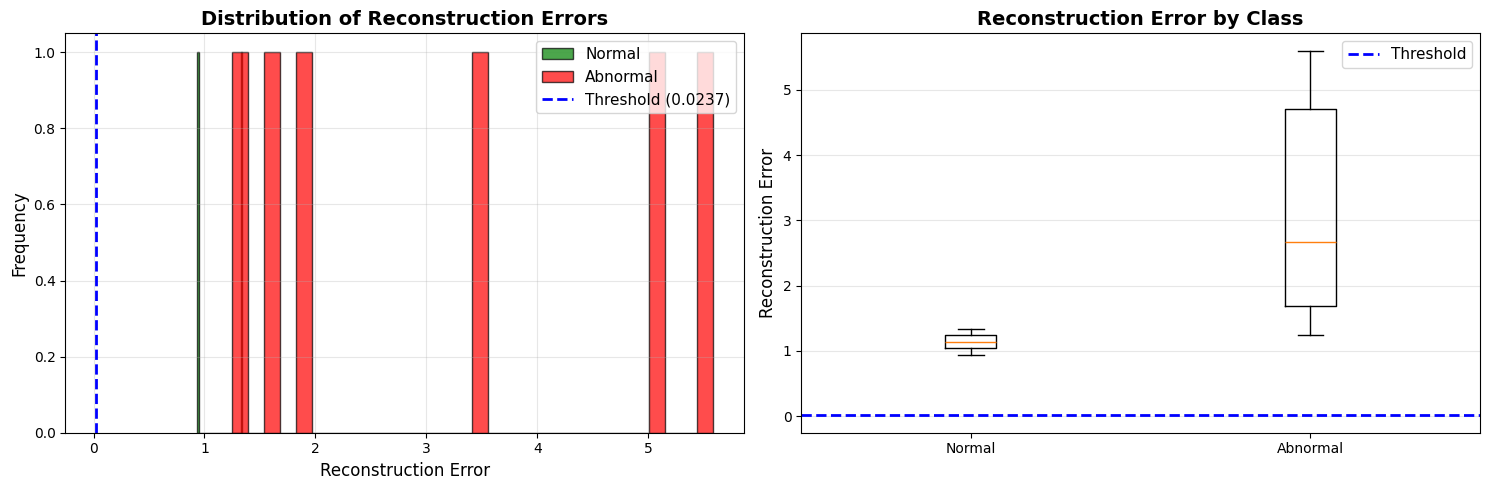

In [26]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 5: Anomaly Detection Evaluation 🎯

# In this exercise, you will:
# 1. Compute reconstruction errors for all datasets
# 2. Set an appropriate threshold for anomaly detection
# 3. Calculate performance metrics
# 4. Visualize the results

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    # Compute reconstruction errors for training data (to set threshold)
    train_reconstructed = model(X_train_tensor)
    train_errors = torch.mean((X_train_tensor - train_reconstructed)**2, dim=1)
    
    # Compute reconstruction errors for test data
    test_reconstructed = model(X_test_tensor)
    test_errors = torch.mean((X_test_tensor - test_reconstructed)**2, dim=1)

# Set threshold as 95th percentile of training errors
threshold = torch.quantile(train_errors, 0.95).item()

print(f"📊 Reconstruction Error Statistics:")
print(f"   Training (normal) - Mean: {train_errors.mean().item():.6f}, Std: {train_errors.std().item():.6f}")
print(f"   Test set - Mean: {test_errors.mean().item():.6f}, Std: {test_errors.std().item():.6f}")
print(f"   Threshold (95th percentile): {threshold:.6f}")

# Classify test samples as anomaly if error > threshold
predictions = (test_errors > threshold).float()

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test_tensor.numpy(), predictions.numpy())
precision = precision_score(y_test_tensor.numpy(), predictions.numpy(), zero_division=0)
recall = recall_score(y_test_tensor.numpy(), predictions.numpy())
f1 = f1_score(y_test_tensor.numpy(), predictions.numpy())

print(f"\n🎯 Anomaly Detection Performance:")
print(f"   Accuracy:  {accuracy:.3f}")
print(f"   Precision: {precision:.3f} (of flagged anomalies, how many are true?)")
print(f"   Recall:    {recall:.3f} (of true anomalies, how many did we catch?)")
print(f"   F1 Score:  {f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test_tensor.numpy(), predictions.numpy())
print(f"\n📋 Confusion Matrix:")
print(f"               Predicted")
print(f"             Normal  Abnormal")
print(f"Actual Normal    {cm[0,0]:3d}     {cm[0,1]:3d}")
print(f"      Abnormal   {cm[1,0]:3d}     {cm[1,1]:3d}")

# Visualize reconstruction error distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of errors
test_normal_errors = test_errors[y_test_tensor == 0].numpy()
test_abnormal_errors = test_errors[y_test_tensor == 1].numpy()

axes[0].hist(test_normal_errors, bins=30, alpha=0.7, label='Normal', color='green', edgecolor='black')
axes[0].hist(test_abnormal_errors, bins=30, alpha=0.7, label='Abnormal', color='red', edgecolor='black')
axes[0].axvline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')
axes[0].set_xlabel('Reconstruction Error', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Reconstruction Errors', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot([test_normal_errors, test_abnormal_errors], labels=['Normal', 'Abnormal'])
axes[1].axhline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold')
axes[1].set_ylabel('Reconstruction Error', fontsize=12)
axes[1].set_title('Reconstruction Error by Class', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
